# Implementation of Simulate Signal

On this notebook it will be implemented a model to create a simulation of events based on real acquisition with ZYNQ 7000 XADC module, teh real signals where acquired at 1 MHz Frequency sample.

The model will consider the noise, also it will consider the equation model for radioactive events making possible to simulate the events with different amplitudes and durations based on a time vector

### Loading necessary libraries

In [1]:
# Importacion de librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import lfilter, firwin, freqz
from scipy.fft import fft, ifft, fftfreq
from scipy.optimize import curve_fit

- Modelo de eventos radioactivos

$y(t) = A(e^{(t-t_0)/\tau_D}-e^{(t-t_0)/\tau_R})$

Donde:

$A$ es Constante proporcional de Amplitud

$\tau_D$ es constante de tiempo de decaimiento de pulso

$\tau_R$ es constante de tiempo de subida de pulso

$t_0$ es Tiempo de ocurrencia del pulso

### Carga de datos

Estos datos fueron registrados con el XADC a una frecuencia de muestreo de 1 MHz



In [2]:
Fs = 1E6   # 1 MHz

data = pd.read_csv("data/data_02.csv")
real_data = np.array(data.iloc[:,1].values, dtype=float)

t = np.arange(0,(len(real_data)/Fs), 1/Fs)

print(real_data.shape)

(250000,)


Text(0.5, 0, 'Time ($\\mu s$)')

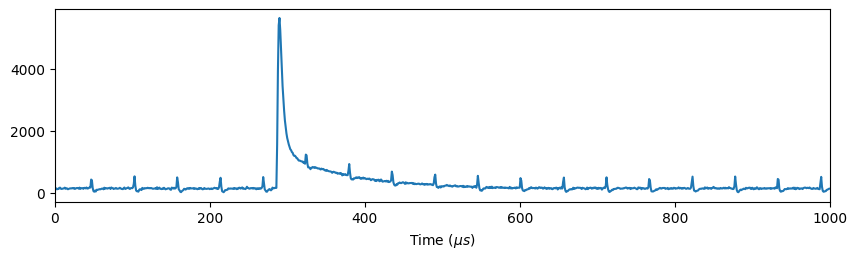

In [17]:
t_ = (t - 0.1273) * 1E6

plt.figure(figsize=(10,2.5))
plt.plot(t_,real_data)
#plt.xlim([0.1273,0.1283])
plt.xlim([0 ,0.001*1E6])
plt.xlabel("Time ($\mu s$)")

### Extraccion del fragmento de señal 

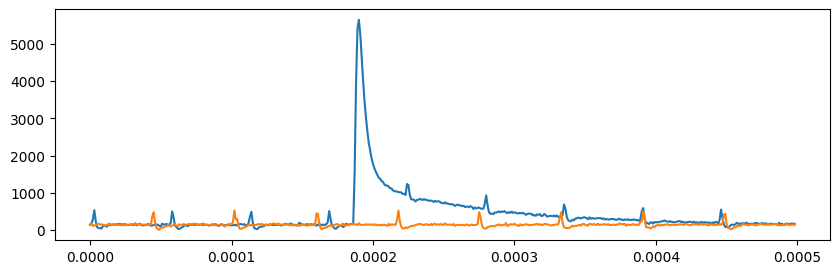

In [5]:
reduced_real  = real_data[int(0.1274*Fs):int(0.1279*Fs)-1]
reduced_noise = real_data[int(0*Fs):int(0.0005*Fs)-1]
#reduced_real = reduced_real/np.max(reduced_real)
reduced_t = np.arange(0,(len(reduced_real)/Fs), 1/Fs)

plt.figure(figsize=(10,3))
plt.plot(reduced_t,reduced_real)
plt.plot(reduced_t,reduced_noise)

### Implementacion del modelo basado en ecuacion

- https://github.com/fabioc9675/ICTP_SOC_Course/blob/main/laboratory/labs/project1_part1/scripts/LabProject_part1.ipynb
- https://gitlab.com/ictp-mlab/smr-3891/-/blob/main/Labs/LabProject/part_1/scripts/pulsefit.py?ref_type=heads
- https://gitlab.com/ictp-mlab/smr-3891/-/wikis/Labs/Project-Stage-1

In [6]:
def radiation_event(t, A, t_0, tau_D, tau_R):
    # return A*np.exp(-((t-t_0)/tau_D))*np.heaviside(t-t_0, 1)
    return (A*((np.exp(-(t - t_0)/tau_D) - np.exp(-(t - t_0)/tau_R))))*np.heaviside(t-t_0, 1)

In [7]:
val_init = [10000, 0.000178, 5e-6, 1e-6] # Valores semilla

#fit_tauDecay       1.069849e-06
#fit_tauRise        3.946262e-07
#fit_tArrival_t0    1.010801e-05


opt_val, cov = curve_fit(radiation_event, reduced_t, reduced_real, val_init)

print('Valores de ajuste: {}'.format(opt_val))

Valores de ajuste: [4.21848077e+03 1.86874015e-04 2.69540167e-05 2.66419618e-07]


C:\Users\fabio\AppData\Local\Temp\ipykernel_32452\4209223959.py:3: RuntimeWarning: overflow encountered in exp
  return (A*((np.exp(-(t - t_0)/tau_D) - np.exp(-(t - t_0)/tau_R))))*np.heaviside(t-t_0, 1)
C:\Users\fabio\AppData\Local\Temp\ipykernel_32452\4209223959.py:3: RuntimeWarning: overflow encountered in multiply
  return (A*((np.exp(-(t - t_0)/tau_D) - np.exp(-(t - t_0)/tau_R))))*np.heaviside(t-t_0, 1)
C:\Users\fabio\AppData\Local\Temp\ipykernel_32452\4209223959.py:3: RuntimeWarning: invalid value encountered in multiply
  return (A*((np.exp(-(t - t_0)/tau_D) - np.exp(-(t - t_0)/tau_R))))*np.heaviside(t-t_0, 1)


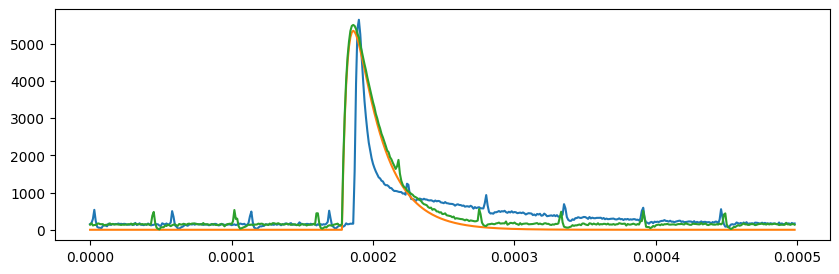

In [14]:
modeled_real = radiation_event(reduced_t, val_init[0], val_init[1], 4*val_init[2], 4*val_init[3])

plt.figure(figsize=(10,3))
plt.plot(reduced_t,reduced_real)
plt.plot(reduced_t,modeled_real)
plt.plot(reduced_t,modeled_real+reduced_noise)

## Creacion de una señal de 1 segundo con 10 eventos aleatorios

Creacion del vector de ruido base y de la señal de eventos

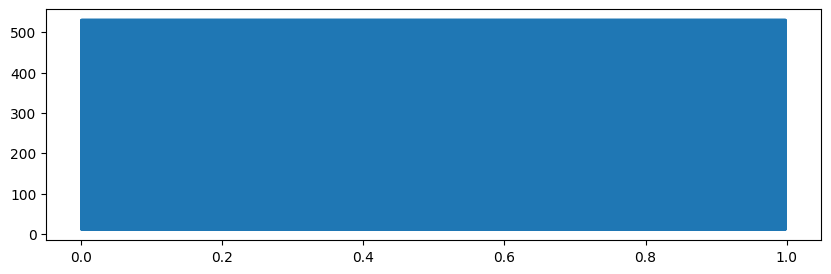

In [15]:
noise_s = reduced_noise
for i in range(0,2001):
    noise_s = np.append(noise_s, reduced_noise)

t_s = np.arange(0,((len(noise_s)-1)/Fs), 1/Fs)

plt.figure(figsize=(10,3))
plt.plot(t_s,noise_s)

Creacion de la señal con pulsos

22


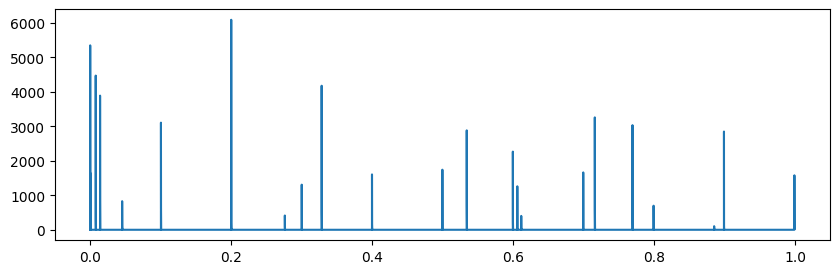

In [16]:
signal_s = radiation_event(reduced_t, val_init[0], val_init[1], val_init[2], val_init[3])
events = 0
for i in range(0,2001):
    A_rand = np.abs(np.random.random())
    t0_rand = np.abs(np.random.random())
    TR_rand = np.abs(5*np.random.random())
    TD_rand = np.abs(5*np.random.random())

    if (i % 200)== 0 or (np.random.randint(300))< 2:
        signal_s = np.append(signal_s, radiation_event(reduced_t, A_rand*val_init[0], t0_rand*val_init[1], 4*TD_rand*val_init[2], 4*TR_rand*val_init[3]))
        events += 1
    else:
        signal_s = np.append(signal_s, np.zeros(len(reduced_t)))

signal_s = np.abs(signal_s)

plt.figure(figsize=(10,3))
plt.plot(t_s,signal_s)
print(events)

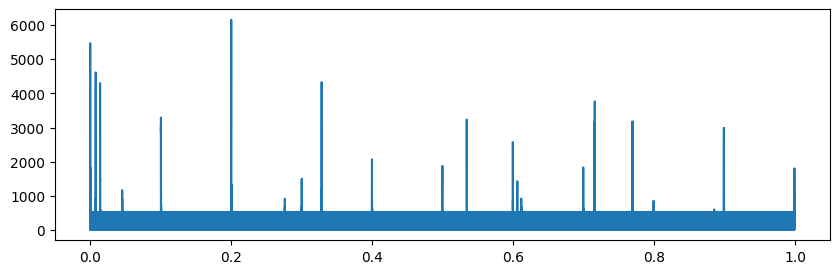

In [17]:
signal_comp = signal_s + noise_s

plt.figure(figsize=(10,3))
plt.plot(t_s,signal_comp)
#plt.xlim([0.698, 0.70])

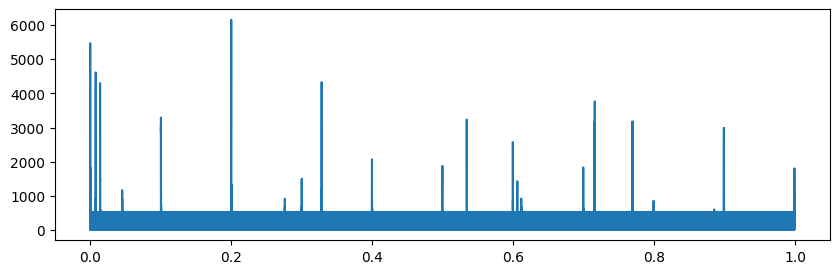

In [18]:
plt.figure(figsize=(10,3))
plt.plot(t_s,signal_comp)

In [19]:
data = np.round(signal_comp).astype(int)
df = pd.DataFrame(data)
df.to_csv('data_s2.csv', index=False)